In [23]:
%matplotlib inline

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import abc
import networkx as nx
import scipy.stats as stats
import matplotlib.animation as animation
import matplotlib

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(linewidth=200, suppress=True)

# Differential Equation Solver

### Various solvers available (Default: Runge-Kutta)

In [25]:
class DynamicsSolver():

    def __init__(self, fx, x0, t0=0.0, delta_t=0.001, nsteps=10000, solver=None, 
                 sstep=100, threshold=1e-12, apply_threshold=False):
        self.fx = fx
        self.x0 = x0
        self.t0 = t0
        self.delta_t = delta_t
        self.nsteps = nsteps
        self.sstep = sstep
        self.threshold = threshold
        self.apply_threshold = apply_threshold

        self.methods = {self.euler: "Euler's method", self.improved_euler: "Improved Euler's method",
                        self.runge_kutta: "Runge-Kutta method"}
        
        if not solver:
            self.solver = self.runge_kutta

    def euler(self, xi):
        delta_x = self.fx(xi) * self.delta_t
        return delta_x

    def improved_euler(self, xi):
        xi_plus_one = xi + self.fx(xi) * self.delta_t
        delta_x = 0.5 * (self.fx(xi) + self.fx(xi_plus_one)) * self.delta_t
        return delta_x

    def runge_kutta(self, xi):
        k1 = self.fx(xi) * self.delta_t
        k2 = self.fx(xi + 0.5 * k1) * self.delta_t
        k3 = self.fx(xi + 0.5 * k2) * self.delta_t
        k4 = self.fx(xi + k3) * self.delta_t
        delta_x = (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        return delta_x

    def solve(self):
        x = []
        xi = np.copy(self.x0)
        for i in range(self.nsteps):
            if i % self.sstep == 0: # keep that value
                x.append(np.copy(xi))
            delta_x = self.solver(xi)
            xi += delta_x

            # if threshold
            if self.apply_threshold:
                if sum(np.fabs(delta_x)) < self.threshold:
                    break

        return np.array(x)

    def xt(self, x, t):
        index = int((t - self.t0) / (self.delta_t * self.sstep))
        return x[index]

    def t(self):
        return [self.t0 + i * (self.sstep * self.delta_t) for i in range(int(self.nsteps / self.sstep))]

### Plot a time series

In [26]:
def plot_time_series(title, x, t, labels=None, x_min=0, x_max=5, t_min=0, t_max=10):
    # axes
    plt.plot([t_min, t_max], [0, 0], lw=1, color="black")
    plt.plot([0, 0], [x_min, x_max], lw=1, color="black")
    plt.grid()

    handles = plt.plot(t, x)
    plt.xlim([t_min, t_max])
    plt.ylim([x_min, x_max])
    plt.title("Time series: " + title)
    plt.xlabel("t")
    plt.ylabel("x(t)")
    if labels:
        plt.legend(handles, labels)

# Basic Abstract Class for Dynamical Systems

In [27]:
class DynamicalSystem:

    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def fx(self, x):  # a system needs to implement differential equations in this function
        return

# Logistic Growth
### System Definition

In [28]:
class LogisticGrowth(DynamicalSystem):

    def __init__(self, r, K):
        self.r = r
        self.K = K

    def fx(self, x):
        return self.r * x * (1.0 - x / K)

### Few Examples

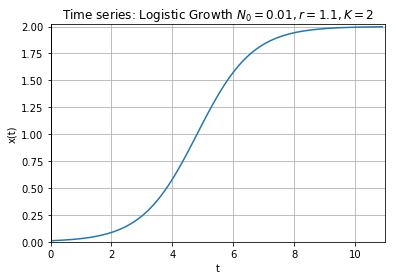

In [29]:
# slower growth
r = 1.1
K = 2
logistic = LogisticGrowth(r, K)
N0 = 0.01

solver = DynamicsSolver(logistic.fx, N0, nsteps=11000)
N = solver.solve()
t = solver.t()

plot_time_series('Logistic Growth $N_0=%3.2f, r=%2.1f, K=%d$' % (N0, r, K), N, t, x_max=K*1.01, t_max=11)
plt.draw()

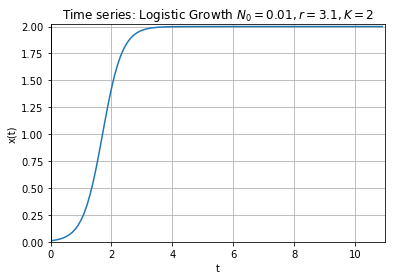

In [30]:
# faster growth
logistic.r = 3.1
N = solver.solve()

plot_time_series('Logistic Growth $N_0=%3.2f, r=%2.1f, K=%d$' % (N0, logistic.r, K), N, t, x_max=K*1.01, t_max=11)
plt.draw()

# Generelized Linear System

In [31]:
class LinearSystem(DynamicalSystem):

    def __init__(self, A):
        self.A = A

    def fx(self, x):
        return np.dot(self.A, x)

### Romeo and Juliet

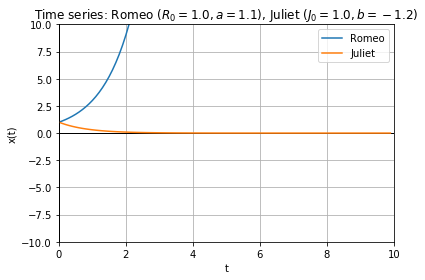

In [32]:
# model parameters and initial values
a = 1.1
b = -1.2
x0 = np.array([1.0, 1.0])

# react only to themselves
A = np.array([[a, 0], [0, b]])
rj = LinearSystem(A)

# solver
solver = DynamicsSolver(rj.fx, x0)
x = solver.solve()
t = solver.t()

plot_time_series('Romeo ($R_0=%2.1f, a=%2.1f$), Juliet ($J_0=%2.1f, b=%2.1f$)' % (x0[0], a, x0[1], b), 
                 x, t, ['Romeo', 'Juliet'], x_min=-10, x_max=10, t_max=10)
plt.draw()

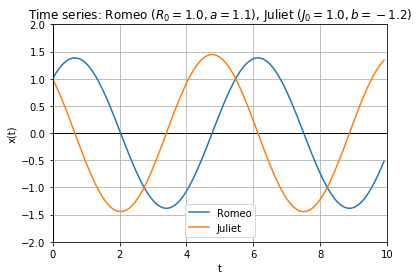

In [33]:
# react only to each other
A = np.array([[0, a], [b, 0]])
rj.A = A

x = solver.solve()

plot_time_series('Romeo ($R_0=%2.1f, a=%2.1f$), Juliet ($J_0=%2.1f, b=%2.1f$)' % (x0[0], a, x0[1], b), 
                 x, t, ['Romeo', 'Juliet'], x_min=-2, x_max=2, t_max=10)
plt.draw()

# Epidemics

### SI Model

In [34]:
class SI(DynamicalSystem):

    def __init__(self, beta):
        self.beta = beta

    def fx(self, x):
        return self.beta * (1.0 - x) * x

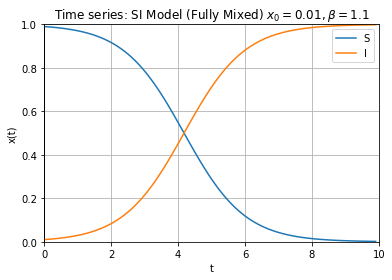

In [35]:
beta = 1.1
si = SI(beta)
x0 = np.array([0.01])

# solver
solver = DynamicsSolver(si.fx, x0)
x = solver.solve()
t = solver.t()
s = np.array([[(1 - y[0]) for y in x]])
y = np.concatenate((s.T, x), axis=1)

plot_time_series('SI Model (Fully Mixed) $x_0=%3.2f, \\beta=%2.1f$' % (x0, beta), y, t, ['S', 'I'], x_max=1)
plt.show()

### SIR Model

In [36]:
class SIR(DynamicalSystem):

    def __init__(self, beta, gamma):
        self.beta = beta
        self.gamma = gamma

    def fx(self, x):
        xn = np.zeros(2)
        xn[0] = -self.beta * x[0] * x[1]
        xn[1] = self.beta * x[0] * x[1] - self.gamma * x[1]
        return xn

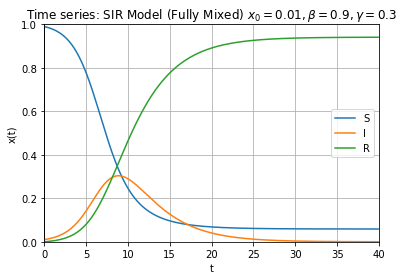

In [37]:
beta = 0.9
gamma = 0.3
sir = SIR(beta, gamma)
x0 = np.array([0.99, 0.01])

# solver
solver = DynamicsSolver(sir.fx, x0, nsteps=40000)
x = solver.solve()
t = solver.t()
r = np.array([[(1 - y[0] - y[1]) for y in x]])
y = np.concatenate((x, r.T), axis=1)
plot_time_series('SIR Model (Fully Mixed) $x_0=%3.2f, \\beta=%2.1f, \gamma=%2.1f$' % (x0[1], beta, gamma),
                 y, t, ['S', 'I', 'R'], x_max=1, t_max=40)
plt.show()

### SIS Model

In [38]:
class SIS(DynamicalSystem):

    def __init__(self, beta, gamma):
        self.beta = beta
        self.gamma = gamma

    def fx(self, x):
        return self.beta * (1.0 - x) * x - self.gamma * x

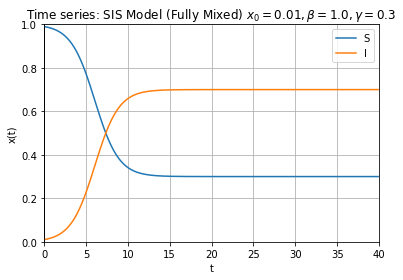

In [39]:
beta = 1.0
gamma = 0.3
sis = SIS(beta, gamma)
x0 = np.array([0.01])

# solver
solver = DynamicsSolver(sis.fx, x0, nsteps=40000)
x = solver.solve()
t = solver.t()
s = np.array([[(1 - y[0]) for y in x]])
y = np.concatenate((s.T, x), axis=1)
plot_time_series('SIS Model (Fully Mixed) $x_0=%3.2f, \\beta=%2.1f, \gamma=%2.1f$' % (x0, beta, gamma),
                 y, t, ['S', 'I'], x_max=1, t_max=40)
plt.show()

### SIRS Model

In [40]:
class SIRS(DynamicalSystem):

    def __init__(self, beta, gamma, delta):
        self.beta = beta
        self.gamma = gamma
        self.delta = delta

    def fx(self, x):
        xn = np.zeros(2)
        xn[0] = -self.beta * x[0] * x[1] + self.delta * (1.0 - x[0] - x[1])
        xn[1] = self.beta * x[0] * x[1] - self.gamma * x[1]
        return xn

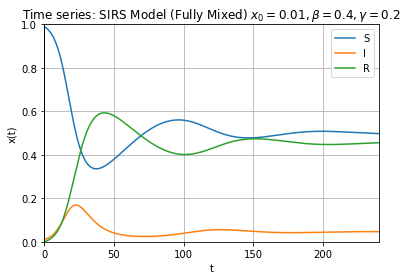

In [41]:
beta = 0.4
gamma = 0.2
delta = 0.02
sirs = SIRS(beta, gamma, delta)
x0 = np.array([0.99, 0.01])

# solver
solver = DynamicsSolver(sirs.fx, x0, nsteps=240000)
x = solver.solve()
t = solver.t()
r = np.array([[(1 - y[0] - y[1]) for y in x]])
y = np.concatenate((x, r.T), axis=1)
plot_time_series('SIRS Model (Fully Mixed) $x_0=%3.2f, \\beta=%2.1f, \gamma=%2.1f$' % (x0[1], beta, gamma),
                 y, t, ['S', 'I', 'R'], x_max=1, t_max=240)
plt.draw()

### SI Model on a network

In [42]:
class SINetwork(DynamicalSystem):

    def __init__(self, beta, A):
        self.beta = beta
        self.A = A

    def fx(self, x):
        #ones = np.ones(len(x))
        return self.beta * (1.0 - x) * np.dot(self.A, x)
        #return np.dot(self.A, x)

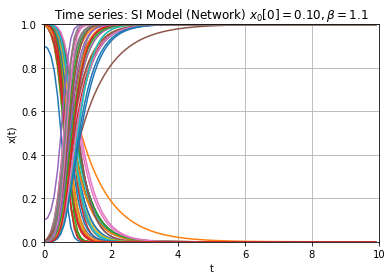

In [43]:
beta = 1.1
G = nx.karate_club_graph()
A = nx.adjacency_matrix(G).todense().A
n, n = A.shape

# system
sin = SINetwork(beta, A)
x0 = np.array([0.1] + [0] * (n - 1))

# solver
solver = DynamicsSolver(sin.fx, x0)
x = solver.solve()
t = solver.t()

s = np.array([np.array([(1 - y) for y in xt]) for xt in x])
y = np.concatenate((s, x), axis=1)
plot_time_series('SI Model (Network) $x_0[0]=%3.2f, \\beta=%2.1f$' % (x0[0], beta),
                 y, t, x_max=1)
plt.draw()

### Correlation with the eigenvector centralities

In [44]:
# calculates the centrality
def centralities(A, alpha=1.0, const_term=False, normalize=True, threshold=1e-6, nsteps=100):
    n, n = A.shape
    x = np.ones(n)
    x /= np.linalg.norm(x)
    xi = [x]
    for i in range(nsteps):
        x_new = alpha * np.dot(A, x)
        if const_term:
            x_new += np.ones(n)
        if normalize:
            x_new /= np.linalg.norm(x_new) # normalize to a unit vector
        dist = np.linalg.norm(x-x_new) # distance to the previous iteration
        x = x_new
        xi.append(x)
        if dist < threshold:
            break
    return xi

xi = centralities(A)
cent = xi[-1]

ts = [0.1, 0.5, 1.0, 2.0, 5.0, 9.0]
for time in ts:
    xt = solver.xt(x, time)
    r = stats.pearsonr(xt, cent)
    print('Correlation r=%10.9f, between eigenvector and probability of infection (time=%2.1f)' % (r[0], time))

Correlation r=0.453983377, between eigenvector and probability of infection (time=0.1)
Correlation r=0.771744594, between eigenvector and probability of infection (time=0.5)
Correlation r=0.902065553, between eigenvector and probability of infection (time=1.0)
Correlation r=0.540840416, between eigenvector and probability of infection (time=2.0)
Correlation r=0.196324307, between eigenvector and probability of infection (time=5.0)
Correlation r=0.182532544, between eigenvector and probability of infection (time=9.0)
